In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
import shap
import joblib

sns.set_style('whitegrid')



In [2]:
os.makedirs('outputs', exist_ok=True)
os.makedirs('models', exist_ok=True)

Data Loading

In [3]:
df = pd.read_csv('clean_train.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:\n{df['y'].value_counts()}")
print(f"Class imbalance ratio: {df['y'].value_counts()[0] / df['y'].value_counts()[1]:.2f}:1")

Dataset shape: (750000, 17)

Target distribution:
y
0    659512
1     90488
Name: count, dtype: int64
Class imbalance ratio: 7.29:1


Handling Class Imbalance with SMOTENC

In [4]:
X = df.drop('y', axis=1)
y = df['y']

cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_index = [X.columns.get_loc(col) for col in cat_features]

# Split first to avoid leakage
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTENC(categorical_features=cat_index, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_raw, y_train)

X_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)
y_train_bal = pd.Series(y_train_bal, name='y')

print(f"Before SMOTENC: {y_train.value_counts().to_dict()}")
print(f"After SMOTENC: {y_train_bal.value_counts().to_dict()}")



Before SMOTENC: {0: 527610, 1: 72390}
After SMOTENC: {0: 527610, 1: 527610}


Feature Engineering & Identification

In [5]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['balance_per_age'] = X['balance'] / (X['age'] + 1)
        X['duration_per_campaign'] = X['duration'] / (X['campaign'] + 1)
        X['has_previous'] = (X['previous'] > 0).astype(int)
        return X

# Identify feature types
num_features = X_train_bal.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train_bal.select_dtypes(include=['object']).columns.tolist()
skewness = X_train_bal[num_features].skew()
high_skew = skewness[skewness >= 1].index.tolist()
normal_skew = skewness[skewness < 1].index.tolist()

print(f"✓ Numerical features: {len(num_features)}")
print(f"✓ Categorical features: {len(cat_features)}")
print(f"✓ High skew features: {len(high_skew)}")
print(f"✓ Normal skew features: {len(normal_skew)}")
print(f"✓ Engineered features: 3 (balance_per_age, duration_per_campaign, has_previous)")



✓ Numerical features: 7
✓ Categorical features: 9
✓ High skew features: 5
✓ Normal skew features: 2
✓ Engineered features: 3 (balance_per_age, duration_per_campaign, has_previous)


Preprocessing Pipeline

In [6]:
high_skew_with_eng = high_skew + ['balance_per_age', 'duration_per_campaign']
normal_skew_with_eng = normal_skew + ['has_previous']

ordinal_categories = [
    ['unknown', 'primary', 'secondary', 'tertiary'],
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
]
ordinal_features = ['education', 'month']
nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
    ('nominal', OneHotEncoder(handle_unknown='ignore', sparse_output=True), nominal_features),
    ('high_skew', PowerTransformer(), high_skew_with_eng),
    ('normal_skew', StandardScaler(), normal_skew_with_eng)
], remainder='passthrough')

print("✓ Preprocessor ready with ordinal, nominal, and numerical transformations")



✓ Preprocessor ready with ordinal, nominal, and numerical transformations


Feature Selection

In [7]:


feature_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    threshold='median'
)
print("Feature selector created (SelectFromModel RF)")



Feature selector created (SelectFromModel RF)


Training Base Models

In [8]:


models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('feature_engineering', FeatureEngineer()),
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector),
        ('classifier', model)
    ])
    pipeline.fit(X_train_bal, y_train_bal)
    y_pred = pipeline.predict(X_test_raw)
    y_proba = pipeline.predict_proba(X_test_raw)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    
    print(f"✓ {name}: F1={results[name]['F1-Score']:.4f}, ROC-AUC={results[name]['ROC-AUC']:.4f}")





Training LogisticRegression...
✓ LogisticRegression: F1=0.6094, ROC-AUC=0.9311

Training RandomForest...
✓ RandomForest: F1=0.6960, ROC-AUC=0.9569

Training GradientBoosting...
✓ GradientBoosting: F1=0.6532, ROC-AUC=0.9502

Training XGBoost...
✓ XGBoost: F1=0.6933, ROC-AUC=0.9602

Training LightGBM...
✓ LightGBM: F1=0.6854, ROC-AUC=0.9584


Model Comparison

In [9]:

results_df = pd.DataFrame(results).T
results_df_sorted = results_df.round(4).sort_values('F1-Score', ascending=False)
print(results_df_sorted)

best_model_name = results_df_sorted.index[0]
print(f"\n🏆 Best Model: {best_model_name}")



                    Accuracy  Precision  Recall  F1-Score  ROC-AUC
RandomForest          0.9154     0.6145  0.8025    0.6960   0.9569
XGBoost               0.9098     0.5878  0.8450    0.6933   0.9602
LightGBM              0.9060     0.5747  0.8489    0.6854   0.9584
GradientBoosting      0.8894     0.5253  0.8632    0.6532   0.9502
LogisticRegression    0.8718     0.4818  0.8290    0.6094   0.9311

🏆 Best Model: RandomForest


Hyperparameter Tuning

In [11]:

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__num_leaves': [20, 31, 40]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.7, 0.8, 0.9]
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }
}

# Select model for tuning
tuning_model = models[best_model_name]
param_grid = param_grids[best_model_name]

tuning_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', tuning_model)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_grid,
    n_iter=5,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_bal, y_train_bal)
best_tuned_pipeline = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


Evaluating Tuned Model

In [12]:

y_pred_tuned = best_tuned_pipeline.predict(X_test_raw)
y_proba_tuned = best_tuned_pipeline.predict_proba(X_test_raw)[:, 1]

tuned_results = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1-Score': f1_score(y_test, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_proba_tuned)
}

print("\nTuned Model Test Results:")
for metric, value in tuned_results.items():
    print(f"  {metric}: {value:.4f}")






Tuned Model Test Results:
  Accuracy: 0.9112
  Precision: 0.5951
  Recall: 0.8273
  F1-Score: 0.6922
  ROC-AUC: 0.9584


Visualizations

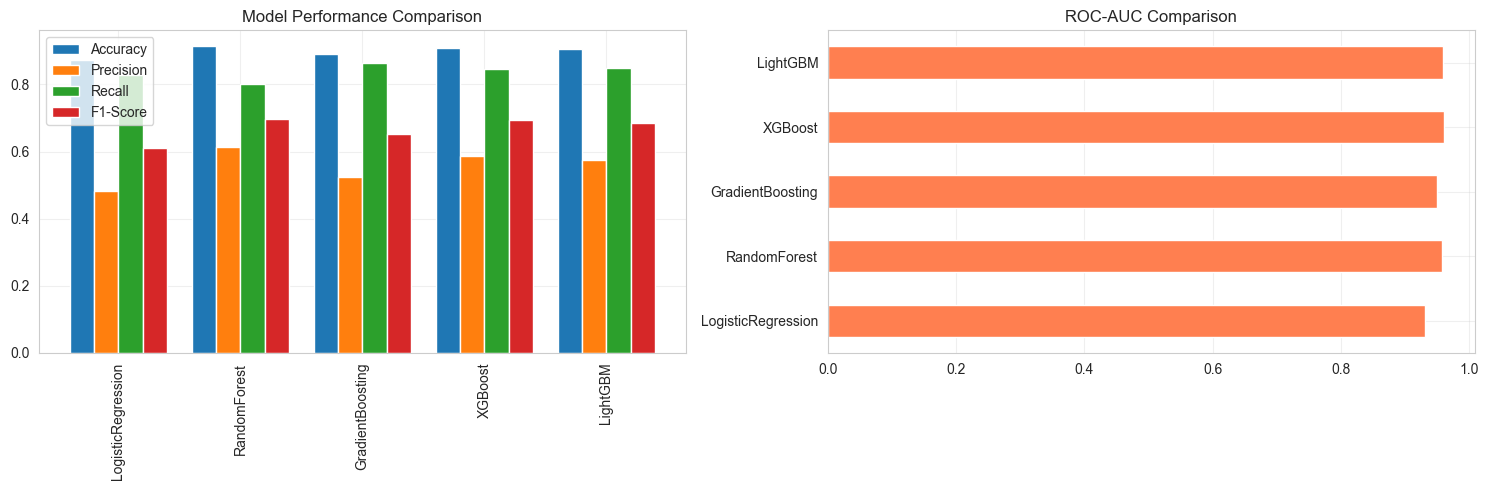

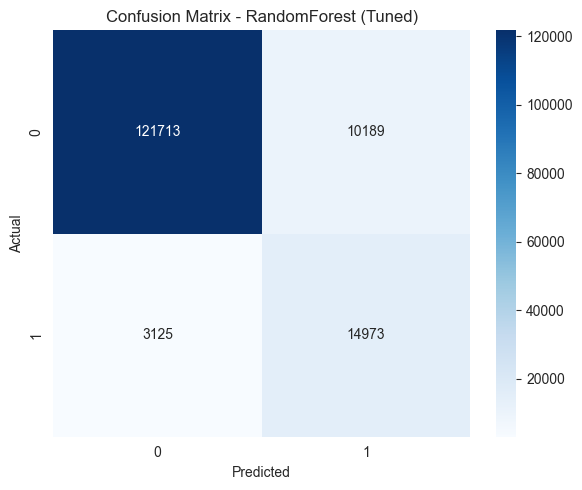

              precision    recall  f1-score   support

          No       0.97      0.92      0.95    131902
         Yes       0.60      0.83      0.69     18098

    accuracy                           0.91    150000
   macro avg       0.79      0.88      0.82    150000
weighted avg       0.93      0.91      0.92    150000



In [13]:

os.makedirs('outputs/plots', exist_ok=True)

# Model Comparison
fig, ax = plt.subplots(1, 2, figsize=(15,5))
results_df[['Accuracy','Precision','Recall','F1-Score']].plot(kind='bar', ax=ax[0], width=0.8)
ax[0].set_title('Model Performance Comparison')
ax[0].grid(alpha=0.3)

results_df['ROC-AUC'].plot(kind='barh', ax=ax[1], color='coral')
ax[1].set_title('ROC-AUC Comparison')
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/plots/model_comparison.png', dpi=300)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} (Tuned)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('outputs/plots/confusion_matrix.png', dpi=300)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_tuned, target_names=['No','Yes']))


Save Pipelline

In [14]:

joblib.dump(best_tuned_pipeline, 'models/best_model.pkl')
results_summary = {
    'best_model': best_model_name,
    'best_params': best_params,
    'test_scores': tuned_results,
    'cv_score': best_cv_score
}
joblib.dump(results_summary, 'models/results_summary.pkl')
print("✓ Model and results saved in 'models/' folder")

✓ Model and results saved in 'models/' folder


SHAP Analysis

In [15]:
import joblib

# Load your trained pipeline
best_tuned_pipeline = joblib.load("models/best_model.pkl")

print("Loaded trained pipeline successfully!")
print(best_tuned_pipeline)


Loaded trained pipeline successfully!
Pipeline(steps=[('feature_engineering', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                                                              'tertiary'],
                                                                             ['jan',
                                                                              'feb',
                                                                              'mar',
                                                                              'apr',
                                                

🔹 Running SHAP analysis for classifier only...
✅ SHAP data shape: (500, 20, 2), Features: 20


<Figure size 800x1000 with 0 Axes>

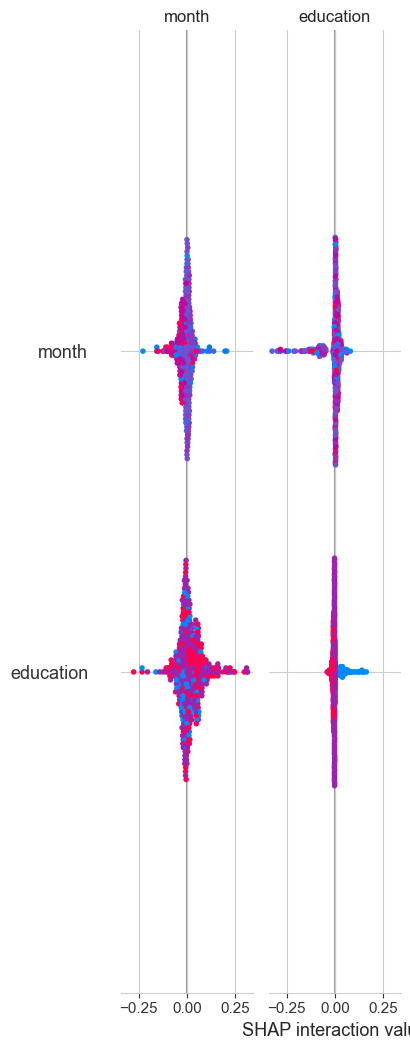

ValueError: Per-column arrays must each be 1-dimensional

In [17]:
# ================================================================
# 🧠 SHAP ANALYSIS — CLASSIFIER LEVEL (Simplified Full Script)
# ================================================================
import shap, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os

print("🔹 Running SHAP analysis for classifier only...")

# --- Sample subset for SHAP ---
X_sample = X_test_raw.sample(n=min(500, len(X_test_raw)), random_state=42)
os.makedirs("outputs/plots/shap", exist_ok=True)

# --- Extract pipeline steps ---
steps = best_tuned_pipeline.named_steps
fe, prep, fs, clf = (
    steps.get("feature_engineering"),
    steps.get("preprocessor"),
    steps.get("feature_selection"),
    steps.get("classifier"),
)

# --- Transform data step by step ---
X_eng = fe.transform(X_sample)
X_prep = prep.transform(X_eng)
X_trans = fs.transform(X_prep) if fs else X_prep

# --- Get feature names ---
try:
    feat_names = prep.get_feature_names_out()
    feat_names = np.array([f.split("__")[-1] for f in feat_names])
except Exception:
    feat_names = np.array(X_eng.columns)

if hasattr(fs, "get_support"):
    feat_names = feat_names[fs.get_support()]
feat_names = np.array([str(f) for f in feat_names])

# ================================================================
# 🔹 SHAP Computation
# ================================================================
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_trans)

# Handle binary/multi-class
if isinstance(shap_vals, list):
    shap_data = shap_vals[1]  # class-1 contributions
else:
    shap_data = shap_vals

# 🔧 FIX: Ensure shapes match
n_features = shap_data.shape[1]
feat_names = feat_names[:n_features]  # Trim to match SHAP output

X_shap = pd.DataFrame(X_trans[:, :n_features], columns=feat_names)
X_shap.columns = X_shap.columns.astype(str)

print(f"✅ SHAP data shape: {shap_data.shape}, Features: {len(feat_names)}")

# ================================================================
# 📊 1️⃣ SHAP Summary Plot (Feature Contribution)
# ================================================================
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_data, X_shap, plot_type="dot", max_display=12, show=False)
plt.tight_layout()
plt.savefig("outputs/plots/shap/shap_summary_dot.png", dpi=300, bbox_inches="tight")
plt.show()

# ================================================================
# 📊 2️⃣ SHAP Bar Plot (Feature Importance)
# ================================================================
mean_shap = np.abs(shap_data).mean(axis=0)

# 🔧 FIX: Ensure both arrays have same length
shap_imp = pd.DataFrame({
    "feature": feat_names[:len(mean_shap)], 
    "importance": mean_shap
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=shap_imp.head(12), x="importance", y="feature", palette="viridis")
plt.title("Top 12 Features by Mean |SHAP| Value")
plt.tight_layout()
plt.savefig("outputs/plots/shap/shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# ================================================================
# 📊 3️⃣ Positive vs Negative Contribution Plot
# ================================================================
shap_df = pd.DataFrame(shap_data, columns=X_shap.columns)
feature_contrib = pd.DataFrame({
    "mean_positive": shap_df[shap_df > 0].mean(),
    "mean_negative": shap_df[shap_df < 0].mean(),
    "mean_abs": shap_df.abs().mean(),
}).fillna(0).sort_values("mean_abs", ascending=False)

plt.figure(figsize=(10, 6))
top_12 = feature_contrib.head(12)
plt.barh(top_12.index, top_12["mean_positive"], color="green", label="Positive (↑ Class 1)")
plt.barh(top_12.index, top_12["mean_negative"], color="red", label="Negative (↓ Class 1)")
plt.xlabel("Mean SHAP Value")
plt.ylabel("Feature")
plt.title("Feature Contribution — Positive vs Negative Impact")
plt.legend()
plt.gca().invert_yaxis()  # Top feature at top
plt.tight_layout()
plt.savefig("outputs/plots/shap/shap_pos_neg.png", dpi=300, bbox_inches="tight")
plt.show()

# ================================================================
# 📄 Save Results
# ================================================================
feature_contrib.to_csv("outputs/plots/shap/shap_feature_contributions.csv", index=True)
print("\n✅ SHAP analysis complete. Results saved in 'outputs/plots/shap/' folder.")
display(feature_contrib.head(12))

Inference on Test Data

In [ ]:

import pandas as pd
import joblib

# Load test data
test_df = pd.read_csv('clean_test.csv')  

# Load trained pipeline
model = joblib.load('models/best_model.pkl')

# Predict
predictions = model.predict(test_df)
probabilities = model.predict_proba(test_df)[:, 1]

# Create result dataframe
results = test_df.copy()
results['predicted_y'] = predictions
results['probability_y'] = probabilities

# Save to CSV
results.to_csv('outputs/test_predictions.csv', index=False)
print("✓ Predictions saved to 'outputs/test_predictions.csv'")


MemoryError: could not allocate 8602176 bytes